<a href="https://colab.research.google.com/github/viniciusrpb/greenalgaclassification/blob/master/selenastraceae_alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
#!pip3 install -U fastai2
#!pip3 install -U fastai
!pip install -Uqq fastbook

#!pip uninstall fastai
#import fastbook
#fastbook.setup_book()

In [28]:
#!ls "/content/drive/My Drive"

!cp -r "/content/drive/My Drive/alga/alga_full" "alga_full"

In [29]:
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
from google.colab import widgets

path_train = 'alga_full'
path_test = 'alga_full'

# New Section

In [30]:
training_set = Path(path_train)

print(training_set)

fns = get_image_files(training_set)

# show an alga image
#img = Image.open('alga_full/239_239_7_5.png')
#img.to_thumb(128,128)

alga_full


### RandomSplitter: always generate the same training and validation tests

In [31]:
#  is to randomly select part of the image, and crop to just that part.
# On each epoch (which is one complete pass through all of our images in the dataset)
# we randomly select a different part of each image.
# This means that our model can learn to focus on, and recognize, different features in our images.

alga_train = DataBlock(
    blocks=(ImageBlock,CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=0), #research how train split is implemented
    get_y=parent_label,
    #item_tfms=RandomResizedCrop(128, min_scale=0.3))
    item_tfms=Resize(224))  #crop the images as squares of 256 x 256
                            # it crops the images to fit a square shape of the size requested
                            # using the full width or height

### Data augmentation

In [32]:
#aug_tfms = transform_basic = [RandomRotate(10), RandomLighting(0.05, 0.05)]

In [33]:
alga_train = alga_train.new(
    item_tfms=Resize(512, ResizeMethod.Pad, pad_mode='reflection'),
    batch_tfms=aug_transforms(do_flip=True,flip_vert=True))
    #batch_tfms=aug_transforms(mult=4, pad_mode='reflection', do_flip=True, 
                                #flip_vert=True,max_rotate=180.0,min_scale=0.5,max_zoom=1.5))#, max_rotate=5.0, align_corners=True, 
                                #max_zoom=0.5, p_affine=0.75, p_lighting=0))
    #batch_tfms=aug_transforms(RandomRotate(10), RandomLighting(0.05, 0.05)))

dls_train_val = alga_train.dataloaders(training_set,bs=64)

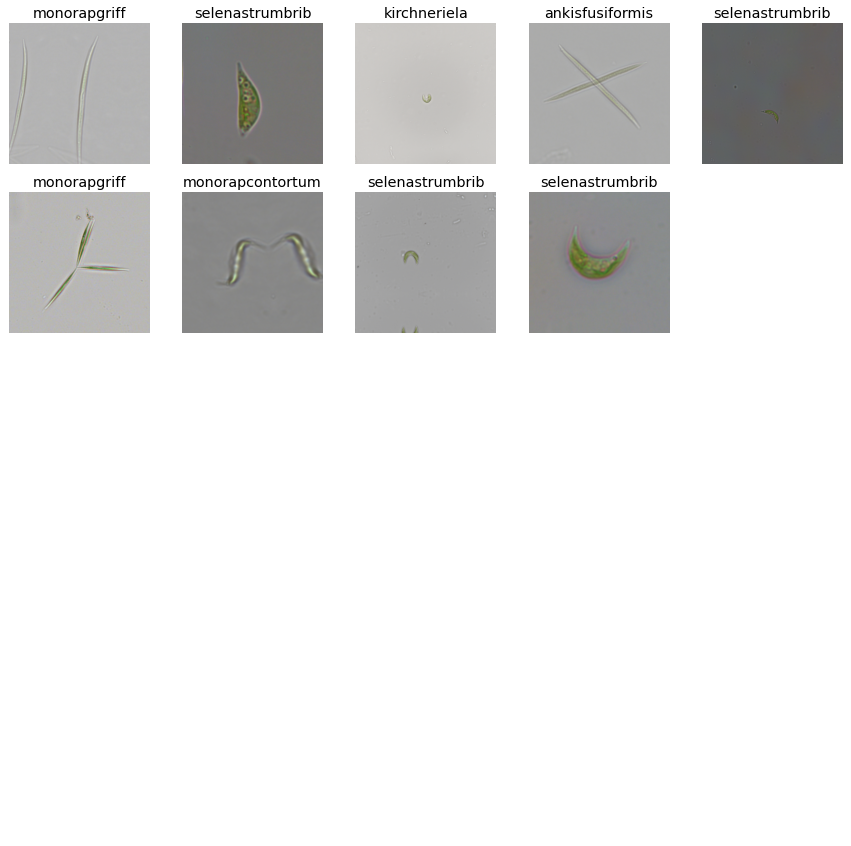

In [34]:
dls_train_val.show_batch(nrows=5, ncols=5)

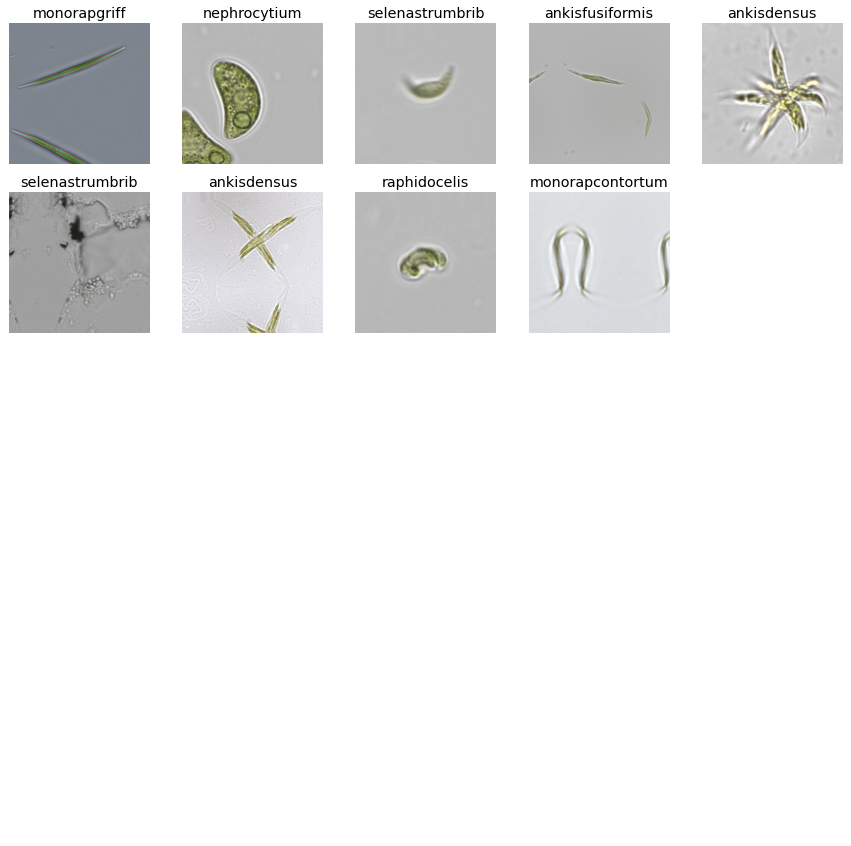

In [35]:
dls_train_val.show_batch(nrows=5, ncols=5)

### Set F1-Score as the official performance measure

In [36]:
f1 = FBeta(average='macro', beta=1)

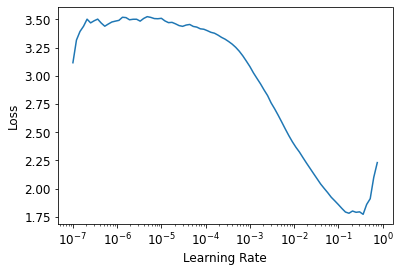

In [37]:
alexnet_learner = cnn_learner(dls_train_val, alexnet, pretrained=True, loss_func = CrossEntropyLossFlat(), metrics=[error_rate,f1])
lr_min,lr_steep = alexnet_learner.lr_find()
#print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

epoch,train_loss,valid_loss,error_rate,fbeta_score,time
0,0.016449,0.000045,0.000000,1.000000,00:09


epoch,train_loss,valid_loss,error_rate,fbeta_score,time
0,0.026404,0.006527,0.006211,0.987166,00:10
1,0.035307,0.022219,0.006211,0.987166,00:10
2,0.052038,0.036705,0.018634,0.975868,00:10
3,0.071727,0.007719,0.000000,1.000000,00:10
4,0.063726,0.001159,0.000000,1.000000,00:10


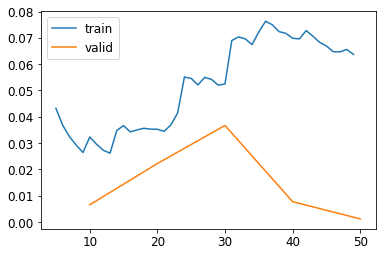

In [47]:
#alexnet_learner.fit_one_cycle(12,0.01)
#alexnet_learner.unfreeze()
#alexnet_learner.fit_one_cycle(12,lr_max=slice(1e-6,1e-4))

#Trains the randomly added layers for one epoch, with all other layers frozen
#Unfreezes all of the layers, and trains them all for the number of epochs requested
alexnet_learner.fine_tune(5,1e-2)
alexnet_learner.recorder.plot_loss()

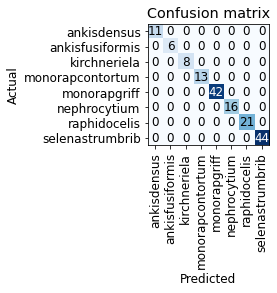

In [39]:
interp = ClassificationInterpretation.from_learner(alexnet_learner)
interp.plot_confusion_matrix()

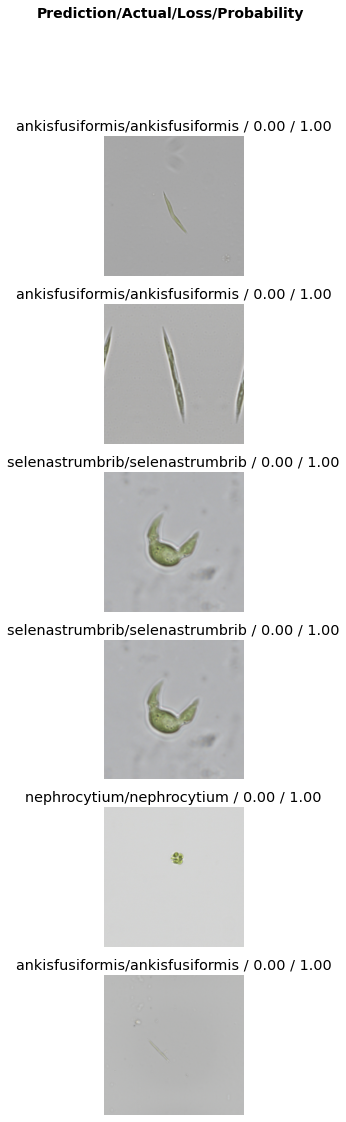

In [40]:
# In the first output shows that the highest loss is an image that has been predicted as
# "monoraphidium" with high confidence, but it was labeled as "selenastraceae"

interp.plot_top_losses(6, nrows=6)

### Evaluation performance using the Test Set

In [41]:
test_set = Path(path_test)

test_files = get_image_files(test_set)

test_dl = alexnet_learner.dls.test_dl(test_files, with_label=True)

In [42]:
pred_probas, _,pred_classes = alexnet_learner.get_preds(dl=test_dl, with_decoded=True)

print(alexnet_learner.dls.vocab)

print(pred_classes)


['ankisdensus', 'ankisfusiformis', 'kirchneriela', 'monorapcontortum', 'monorapgriff', 'nephrocytium', 'raphidocelis', 'selenastrumbrib']
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 

In [43]:
def plotConfusionMatrix(classifier,X_test,y_test,y_pred,class_names):
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(classifier, X_test, y_test,display_labels=class_names,cmap=plt.cm.Blues)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()
    return ;



In [46]:
#print(confusion_matrix(y_test, y_pred))
#plotConfusionMatrix(gnb,X_test,y_test,y_pred,labels)